In [1]:
from functools import partial
import copy
import numpy as np
import matplotlib.pyplot as plt
import cProfile
from mpl_toolkits import mplot3d
import scipy.spatial

# Local imports
import oggm
from oggm.core.massbalance import LinearMassBalance, ScalarMassBalance
from oggm.core.inversion import find_sia_flux_from_thickness
from oggm import utils, cfg
from oggm.cfg import SEC_IN_DAY, SEC_IN_YEAR 
from oggm.core.sia2d import Upstream2D
from oggm.exceptions import InvalidParamsError
cfg.initialize(logging_level='WARNING')

# Tests
from oggm.tests.funcs import (dummy_bumpy_bed, dummy_constant_bed,
                              dummy_constant_bed_cliff,
                              dummy_mixed_bed, dummy_constant_bed_obstacle,
                              dummy_noisy_bed, dummy_parabolic_bed,
                              dummy_trapezoidal_bed, dummy_width_bed,
                              dummy_width_bed_tributary, bu_tidewater_bed,
                              dummy_bed_tributary_tail_to_head)

# after oggm.test
import matplotlib.pyplot as plt

from oggm.core.flowline import (KarthausModel, FluxBasedModel,
                                MassRedistributionCurveModel,
                                MassConservationChecker)

from oggm.tests.ext.sia_fluxlim import MUSCLSuperBeeModel

FluxBasedModel = partial(FluxBasedModel, inplace=True)
KarthausModel = partial(KarthausModel, inplace=True)
MUSCLSuperBeeModel = partial(MUSCLSuperBeeModel, inplace=True)

2022-10-12 16:36:15: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-10-12 16:36:15: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-10-12 16:36:15: oggm.cfg: Multiprocessing: using all available processors (N=16)
2022-10-12 16:36:16: oggm.utils: /Users/jah046/.oggm/downloads.sha256.hdf changed or invalid, deleting.


In [2]:
# Years run, can change up to 700 
yr_start = 0.0 #start year 0
num_yrs = 100 #32 #20 #700
yrs = np.arange(1, num_yrs+1)

# Technically should be able to change but a lot of values break OGGM
ELA = 2600. #2800. #ELA (m)
mdot_grad = 20. #25 #mbgradient (mm/yr/m, default=3.)
mdot_con = 3. #mb (mm/yr)

In [3]:
# Pick Bed Shape, currently only can choose one rectangle, cliff and rectangle, parabolic, trapezoid
use_rectangle = 0
use_cliff = 0
use_parabolic = 1
use_trapezoid = 0

# Pick Mass Balance equation scalar,linear, steady state
use_scalar = 1
use_linear = 0
use_steady = 0

In [4]:
# Coefficients as in OGGM
A = cfg.PARAMS['glen_a'] # Modern style Glen parameter A 2.4e-24
n = cfg.PARAMS['glen_n'] # 3.0
g = 9.81 #m/s^2
rho = cfg.PARAMS['ice_density'] # 900.0kg/m^3
Gamma = 2.0*A*(rho*g)**n/(n+2)
cfl = 0.124
max_dt = 31*SEC_IN_DAY #max timestep in seconds
cfl_number = cfg.PARAMS['cfl_number'] #CFL criterion (dt = cfl_number * dx / max_u

# prevent adaptive time-stepping depending on bed shape
fixed_dt_use = 10 * SEC_IN_DAY #parabolic and constant works
if use_cliff==1: fixed_dt_use = 2 * SEC_IN_DAY   #need for cliff

In [5]:
# Bed shape, can change these
max_elev = 3000. # default 3000m
min_elev = 1000. # default 1000m
Nx = 200         # default 200
dx = 100.        # DEM grid spacing in meters down glacier, default 100m

# Width fixed in OGGM, but changes depending on bed shape
if use_rectangle == 1: the_wid = 100. # this is changeable in OGGM, default 300 m    
if use_cliff     == 1: cliff_hgt=250. # default 250m
if use_parabolic == 1: shape=5.e3    # default 5.e-3 which is flat to eye, if use 5.e3 it's very curved
if use_trapezoid == 1: lambdas=2      # default 2
    
# THESE SHOULD NOT BE CHANGED, fixed in OGGM
if use_cliff     == 1: the_wid = 100. #this is not changeable in OGGM
if use_parabolic == 1: the_wid = 100. #this is not changeable in OGGM, max width of glacier
if use_trapezoid == 1: the_wid = 100. #this is not changeable in OGGM, max width of glacier

dy = 20. #DEM grid spacing in meters across glacier
dxdy=dx*dy
x = np.arange(0.5, Nx + 0.5, 1)*dx
dist = x
x_m = Nx*dx # max length of the glacier
y_m = the_wid #width of the glacier

# do not need this if we take values from OGGM, otherwise initialize
slope_h = np.linspace(max_elev,min_elev,Nx) #elevation[m] of constant slope bedrock at the flowline grid points
bed_h1 = slope_h

In [6]:
#for use_trapezoid and parabolic, should cut and use OGGM numbers
gam = 2
if gam == 2:
    theta = 45
slope_elevation = (max_elev-min_elev)/(x_m)

In [7]:
# define model and beds
#models = [KarthausModel, FluxBasedModel,MUSCLSuperBeeModel]
#mymodels=["Karthaus","Flux Based","MUSCL SB"]
models = [FluxBasedModel]
mymodels=["Flux Based"]

# Karthaus does not work unless constant bed
if (use_parabolic==1 or use_trapezoid==1) and mymodels[0]=="Karthaus":
    models = models[1:]
    mymodels=mymodels[1:]
    
if use_rectangle == 1: modelnames=["OGGM " + s+ " Constant Bed" for s in mymodels]
if use_cliff     == 1: modelnames=["OGGM " + s+ " Constant Bed Cliff" for s in mymodels]
if use_parabolic == 1: modelnames=["OGGM " + s+ " Parabolic Bed" for s in mymodels]
if use_trapezoid == 1: modelnames=["OGGM " + s+ " Trapezoidal Bed" for s in mymodels]

In [8]:
def reset(use_rectangle,use_cliff,use_parabolic,use_trapezoid):
    if use_rectangle == 1: fls = dummy_constant_bed(hmax=max_elev, hmin=min_elev, nx=Nx, map_dx=dx,widths=the_wid/100.)
    if use_cliff     == 1: fls = dummy_constant_bed_cliff(hmax=max_elev, hmin=min_elev, nx=Nx, map_dx=dx,cliff_height=cliff_hgt)
    if use_parabolic == 1: fls = dummy_parabolic_bed(hmax=max_elev, hmin=min_elev, nx=Nx, map_dx=dx,default_shape=shape,from_other_shape=None, from_other_bed=None)
    if use_trapezoid == 1: fls = dummy_trapezoidal_bed(hmax=max_elev, hmin=min_elev, nx=Nx, map_dx=dx,def_lambdas=lambdas)
    return fls

In [9]:
def test_bed(glen_a,yrs,models,mb0):
    lens = []
    surface_h = []
    volume = []
    widths = []
    for model in models:
        
        mb = mb0 
        fls = reset(use_rectangle,use_cliff,use_parabolic,use_trapezoid)
        print(model,fls)

        model = model(fls, mb_model=mb, glen_a=glen_a,y0 = yr_start,
                      fixed_dt=fixed_dt_use)

        length = yrs * 0.
        vol = yrs * 0.
        for i, y in enumerate(yrs):
            model.run_until(y)
            assert model.yr == y
            length[i] = fls[-1].length_m
            vol[i] = fls[-1].volume_km3
        lens.append(length)
        volume.append(vol)
        widths.append(fls[-1].widths_m.copy())
        surface_h.append(fls[-1].surface_h.copy())
        
    bed_h = fls[-1].bed_h
    return(lens, volume, surface_h, widths, bed_h)

In [10]:
# run models and linear MB and save
if use_scalar==1: #  input is mb (mm/yr, default =0) if you make this too positive it will grow out of domain boundaries (- or +10. is okay)
    mb = ScalarMassBalance(mdot_con)
    file = 'test_bed_scalar' #to save
    lens1, volume1, surface_h1, widths1, bed_h1 = test_bed(A,yrs,models,mb)
    np.savez(file, lens=lens1,volume=volume1,surface_h=surface_h1,widths=widths1,bed_h=bed_h1) 
if use_linear==1: #  input is ELA (m, required), gradient (mm/yr/m, default=3.), max mb cap (mm/yr, default=none)
    mb = LinearMassBalance(ELA,mdot_grad)
    file = 'test_bed_linear' #to save
    fls = reset(use_rectangle,use_cliff,use_parabolic,use_trapezoid)
    lens1, volume1, surface_h1, widths1, bed_h1 = test_bed(A,yrs,models,mb)
    np.savez(file, lens=lens1,volume=volume1,surface_h=surface_h1,widths=widths1,bed_h=bed_h1)

functools.partial(<class 'oggm.core.flowline.FluxBasedModel'>, inplace=True) [<oggm.core.flowline.ParabolicBedFlowline object at 0x7fe754800b50>]


In [11]:
#print((surface_h1[0])[19]- bed_h1[19],(surface_h1[0])[20]- bed_h1[20],(surface_h1[0])[21]- bed_h1[21],bed_h1[19],bed_h1[20])

In [12]:
# numerical Methods
use_E = 0 #Euler
use_TVD = 1 #TVD runge Kutta Method
use_nTVD = 0 #Non TVD Runge Kutta Method

#needs to be added
use_minmod = 0 #minmod function
use_superbee = 1 #superbee function

#shallow ice solving method
use_upstream = 1
use_MUSCL = 0

In [13]:
# define methods
methods = []
if use_upstream: methods = methods + ["upstream"]
if use_MUSCL: methods = methods + ["MUSCL"]
    
if use_rectangle == 1: methodnames=["My Model " + s+ " Constant Bed" for s in methods]
if use_cliff     == 1: methodnames=["My Model " + s+ " Constant Bed Cliff" for s in methods]
if use_parabolic == 1: methodnames=["My Model " + s+ " Parabolic Bed" for s in methods]
if use_trapezoid == 1: methodnames=["My Model " + s+ " Trapezoidal Bed" for s in methods]

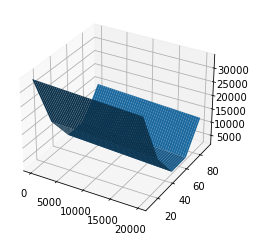

In [14]:
#Bed array initialize
Ny = int(the_wid/dy ) #want this to be odd
y = np.arange(0.5, Ny+0.5, 1)*dy
B = np.zeros((Ny,Nx)) 

if use_cliff or use_rectangle == 1:
    for yd in range(Ny):
        for xd in range(Nx):
            B[yd][xd] = bed_h1[xd]
    Mny = int((Ny+1.)/2.) #if odd Ny, this will be center FD coordinate, otherwise will not be center
                        
if use_trapezoid == 1:
    w0 = y_m-2*b_0
    for yd in range(Ny):
        for xd in range(Nx):
            if y[yd] <= (y_m-w0)/gam:
                base = (y_m-w0)/gam-y[yd]
                B[yd][xd] = base*np.tan(theta) #-(slope_elevation)*x[xd]+max_elev
            if y[yd] >= (y_m-w0)/gam+w0:
                base = y[yd]-(y_m-w0)/gam-w0
                B[yd][xd] = base*np.tan(theta) #-(slope_elevation)*x[xd]+max_elev
            B[yd][xd] = B[yd][xd]-(slope_elevation)*x[xd]+max_elev
    Mny = int((Ny+1.)/2.) #if odd Ny, this will be center FD coordinate, otherwise will not be center
    
if use_parabolic == 1:
    for yd in range(Ny):
        for xd in range(Nx):
            B[yd][xd]=shape*(yd-Ny/2)**2+bed_h1[xd]
    Mny = int(Ny/2)
    

By,Bx= np.meshgrid(y,x, indexing = 'ij') #2D array of bed size/shape
ax = plt.axes(projection='3d')
ax.plot_surface(Bx, By, B, linewidths=1.0)

In [15]:
# standard minmod function
def minmod(a,b):
    sign = (np.sign(a)+np.sign(b))
    minmod = sign/2*(np.minimum(np.abs(a), np.abs(b)))
    return minmod

def superbee(r):
    superbee =np.maximum(0,np.minimum(2.*r,1), np.minimum(r,2.)) 
    return superbee

# flux
def flux(sjpl, sjml, sjplp, sjmlp, sjlp, sjl, dj, dl):
    flux = (((((sjpl-sjml)+sjplp-sjmlp)**2.) / (4.*dj)**2.)+(sjlp-sjl)**2./dl**2. )**((n-1.)/2.)
    return flux


# Shallow Ice approximation
def SIA(Dup, Sup, S, Ddn, Sdn, d):
    SIA=((Dup * (Sup - S))/d - (Ddn * (S - Sdn))/d)/d #equation 36 Jarosh 2013
    return SIA

# index
def H_index(h1, h2):
    H_index = 0.5*(h1+h2)
    return H_index

# H up index
def H_plus(Hm, H, Hp):
    if use_minmod == 1:
        H_plus = H - 0.5*minmod((H-Hm),(Hp-H))*(Hp-H)
    if use_superbee == 1:
        H_plus=H*0
        H_plus[Hp!=H] = (H - 0.5*superbee((H-Hm)/(Hp-H))*(Hp-H))[Hp!=H]
    return H_plus

# H down index
def H_min(Hm, H, Hp):
    if use_minmod == 1:
        H_min = H + 0.5*minmod((H-Hm),(Hp-H))*(Hp-H)
    if use_superbee == 1:
        H_min=H*0
        H_min[Hp!=H] = (H + 0.5*superbee((H-Hm)/(Hp-H))*(Hp-H))[Hp!=H]
    return H_min     
    
# Methods    
# Euler
def E(u, Lu, deltat):
    E = u-deltat*Lu
    return E

# TVD second order Runge-Kutta method
def TVDu1(u, Lu, deltat):
    TVDu1 = u+deltat*Lu
    return TVDu1

def TVD(u, Lu, L1, deltat):
    TVD = u+(0.5)*deltat*Lu+1/2*deltat*L1
    return TVD

# non TVD Runge-Kutta method method
def nTVDu1(u, Lu, deltat):
    nTVDu1 = u-20*deltat*Lu
    return nTVDu1

def nTVD(u, Lu, L1, deltat):
    nTVD = u+(41.0/40.0)*deltat*Lu-1.0/40.0*deltat*L1
    return nTVD

#steady State
def accumulationss(x,mdot_0,n,x_m): 
    mdot = ((n*mdot_0)/(x_m**(2.*n-1.)))*x**(n-1.)*(abs(x_m-x)**(n-1.))*(x_m-2.*x) # Eq. 54 Jarosch 2013, m/yr
    mdot[x>x_m] = 0.
    return mdot

#Linear
def accumulationl(heights):
    mdot = (heights-ELA)*(mdot_grad) #m/yr
    return mdot

# Utilities
def trapezoidal_area(xyz):
    """Calculate volume under a surface defined by irregularly spaced points
    using delaunay triangulation. "x,y,z" is a <numpoints x 3> shaped ndarray."""
    d = scipy.spatial.Delaunay(xyz[:,:2])
    tri = xyz[d.vertices]

    a = tri[:,0,:2] - tri[:,1,:2]
    b = tri[:,0,:2] - tri[:,2,:2]
    vol = np.cross(a, b) @ tri[:,:,2]
    return vol.sum() / 6.0

def width_m(H):
    #compute the widths out of H and the bed shape
    if use_rectangle or use_cliff ==1:
        wid = the_wid + H*0.
    if use_parabolic == 1:
        wid = np.sqrt(4*H/shape)
    if use_trapezoid == 1:
        wid = -999  + H*0.#CALCULATE
    return wid
def volume_km3(H):
    if use_rectangle or use_cliff ==1:
        vol3 = np.sum(H*dxdy)*1.e-9
    if use_parabolic == 1:
        vol3 = -999 #CALCULATE
    if use_trapezoid == 1:
        vol3 = -999 #CALCULATE        
    return vol3

In [16]:
# accumulation for m/s at each site, linear updates every year based on glacier surface elevation
def distrib_mb(surface_h):
    m_dot_linear = np.zeros((Ny,Nx))
    m_dot_scalar = np.zeros((Ny,Nx))
    m_dot_steady = np.zeros((Ny,Nx))
    if use_linear==1: 
        mb = LinearMassBalance(ELA,mdot_grad)
        mb_linear = mb.get_annual_mb(surface_h) #m/s?
        for yd in range(Ny):
            for xd in range(Nx):
                m_dot_linear[yd][xd] =  mb_linear[xd] #m/yr 
    if use_scalar==1: 
        mb = ScalarMassBalance(mdot_con)
        mb_scalar = mb.get_annual_mb(surface_h) #m/s
        for yd in range(Ny):
            for xd in range(Nx):
                m_dot_scalar[yd][xd] = mb_scalar[xd] 
    if use_steady==1:
        mdot = accumulationss(x, mdot_con, n, x_m) #m/yr 
        for yd in range(Ny):
            for xd in range(Nx):
                m_dot_steady[yd][xd] = mdot[xd]/SEC_IN_YEAR #m/s
                
    return(m_dot_linear, m_dot_scalar, m_dot_steady)

In [17]:
# finite difference index x direction down the length of the glacier
l = np.arange(0, Nx)
lp = np.hstack([np.arange(1,Nx),Nx-1])
lpp = np.hstack([np.arange(2, Nx), Nx-1, Nx-1])
lm = np.hstack([0, np.arange(0, Nx-1)])
lmm = np.hstack([0, 0, np.arange(0, Nx-2)])

# finite difference index y direction across the glacier
k = np.arange(0, Ny)
kp = np.hstack([np.arange(1,Ny),Ny-1])
kpp = np.hstack([np.arange(2, Ny), Ny-1, Ny-1])
km = np.hstack([0, np.arange(0, Ny-1)])
kmm = np.hstack([0, 0, np.arange(0, Ny-2)])

In [18]:
def diffusion_upstream(S,B):
    H = S-B #H = ice thickness, S = Surface height, B = bed topography  

    #indices
    Sklp = S[k][:,lp]
    Sklm = S[k][:,lm]
    Skplp = S[kp][:,lp]
    Skplm = S[kp][:,lm]
    Skpl = S[kp][:,l]
    Skl = S[k][:,l]
    Skmlp = S[km][:,lp]
    Skmlm = S[km][:,lm]
    Skml = S[km][:,l]
        
    Hkpl = H[kp][:,l]
    Hkml = H[km][:,l]  
    Hkl = H[k][:,l]
    Hklp = H[k][:,lp]  
    Hklm = H[k][:,lm]

    # calculate l upstream
    H_l_up = H_index( Hklp, Hkl )
    H_l_down = H_index( Hkl, Hklm )    

    H_l_upstream_up = np.zeros((Ny,Nx))
        
    H_l_upstream_up[Sklp>Skl]  = Hklp[Sklp>Skl] #THIS HAD INDEX WRONG
    H_l_upstream_up[Skl>=Sklp] = Hkl[Skl>=Sklp] #THIS HAD INDEX WRONG
        
    H_l_upstream_down = np.zeros((Ny,Nx))
    H_l_upstream_down[Skl>Sklm]  = Hkl[Skl>Sklm] #THIS HAD INDEX WRONG
    H_l_upstream_down[Sklm>=Skl] = Hklm[Sklm>=Skl] #THIS HAD INDEX WRONG    

# WHAT DOES IT SAY THAT INDEXES WERE WRONG AND STILL PRINTS SAME THING, MB OFF???
    
    # calculate l flux
    f_l_plus = flux(Skpl, Skml, Skplp, Skmlp, Sklp, Skl, dx, dy)
    f_l_min = flux(Skpl, Skml, Skplm, Skmlm, Skl, Sklm, dx, dy)

    # calculate l Diffusivity
    D_l_up = Gamma * H_l_up**(n+1) * H_l_upstream_up * f_l_plus
    D_l_dn = Gamma * H_l_down**(n+1) * H_l_upstream_down * f_l_min

    # calculate k upstream    
    H_k_up = H_index( Hkpl, Hkl )
    H_k_down = H_index( Hkl, Hkml )
    
    H_k_upstream_up = np.zeros((Ny,Nx))
    H_k_upstream_up[Skpl>Skl]  = Hkpl[Skpl>Skl]
    H_k_upstream_up[Skl>=Skpl] = Hkl[Skl>=Skpl]

    H_k_upstream_down = np.zeros((Ny,Nx))
    H_k_upstream_down[Skl>Skml]  = Hkl[Skl>Skml]
    H_k_upstream_down[Skml>=Skl] = Hkml[Skml>=Skl]

    # calculate k flux
    f_k_plus = flux(Sklp, Sklm, Skplp, Skplm, Skpl, Skl, dy, dx)
    f_k_min = flux(Sklp, Sklm, Skmlp, Skmlm, Skl, Skml, dy, dx)

    # calculate k Diffusivity
    D_k_up = Gamma * H_k_up**(n+1) * H_k_upstream_up * f_k_plus
    D_k_dn = Gamma * H_k_down**(n+1) * H_k_upstream_down * f_k_min

    # calculate delta t and t
    divisor = max(np.max(np.abs(D_k_up)), np.max(np.abs(D_k_dn)), np.max(np.abs(D_l_dn)), np.max(np.abs(D_l_dn)))
    if divisor==0: 
        dt_cfl = max_dt
    else:
        dt_cfl = cfl * min(dx**2., dy**2.) / divisor

    # the timestep
    div_k = SIA(D_k_up, Skpl, Skl, D_k_dn, Skml, dy) #equation 36 Jarosh 2013
    div_l = SIA(D_l_up, Sklp, Skl, D_l_dn, Sklm, dx) #equation 36 Jarosh 2013
    div_q = div_k+div_l

    return div_q, dt_cfl

In [19]:
def diffusion_MUSCL(S,B):
    H = S-B #H = ice thickness, S = Surface height, B = bed topography  
    
    #indices
    Sklp = S[k][:,lp]
    Sklm = S[k][:,lm]
    Skplp = S[kp][:,lp]
    Skplm = S[kp][:,lm]
    Skpl = S[kp][:,l]
    Skl = S[k][:,l]
    Skmlp = S[km][:,lp]
    Skmlm = S[km][:,lm]
    Skml = S[km][:,l]
        
    Hkpl = H[kp][:,l]
    Hkppl = H[kpp][:,l]
    Hkml = H[km][:,l]
    Hkmml = H[kmm][:,l]     
    Hkl = H[k][:,l]
    Hklp = H[k][:,lp]  
    Hklpp = H[k][:,lpp]
    Hklm = H[k][:,lm]
    Hklmm = H[k][:,lmm]
    
    # calculate l+1/2 index
    H_l_min_up = H_min(Hklm, Hkl, Hklp)
    H_l_plus_up = H_plus(Hkl, Hklp, Hklpp)
 
    # calculate l-1/2 index
    H_l_min_down = H_min(Hklmm, Hklm, Hkl)
    H_l_plus_down = H_plus(Hklm, Hkl, Hklp)

    # calculate l flux
    f_l_plus = flux(Skpl, Skml, Skplp, Skmlp, Sklp, Skl, dx, dy)
    f_l_min = flux(Skpl, Skml, Skplm, Skmlm, Skl, Sklm, dx, dy)

    # calculate l Diffusivity
    D_l_up_m = Gamma * H_l_min_up**(n+2.) * f_l_plus #Equation 30 Jarosch 2013
    D_l_up_p = Gamma * H_l_plus_up**(n+2.) * f_l_plus #Equation 30 Jarosch 2013
    D_l_up_min = np.minimum(D_l_up_m, D_l_up_p) #equation 31 Jarosch 2013
    D_l_up_max = np.maximum(D_l_up_m, D_l_up_p) #equation 32 Jarosch 2013
                
    D_l_dn_m = Gamma * H_l_min_down**(n+2) * f_l_min #Equation 30 Jarosch 2013
    D_l_dn_p = Gamma * H_l_plus_down**(n+2) * f_l_min #Equation 30 Jarosh 2013
    D_l_dn_min = np.minimum(D_l_dn_m, D_l_dn_p) #equation 31 Jarosch 2013
    D_l_dn_max = np.maximum(D_l_dn_m, D_l_dn_p) #equatioon 32 Jarosch 2013

    #equation 33 jarosh 2013
    D_l_up = np.zeros((Ny,Nx))
    D_l_up[np.logical_and(Sklp<=Skl,H_l_min_up<=H_l_plus_up)]= D_l_up_min[np.logical_and(Sklp<=Skl,H_l_min_up<=H_l_plus_up)]
    D_l_up[np.logical_and(Sklp<=Skl,H_l_min_up>H_l_plus_up)] = D_l_up_max[np.logical_and(Sklp<=Skl,H_l_min_up>H_l_plus_up)]
    D_l_up[np.logical_and(Sklp>Skl,H_l_min_up<=H_l_plus_up)] = D_l_up_max[np.logical_and(Sklp>Skl,H_l_min_up<=H_l_plus_up)]
    D_l_up[np.logical_and(Sklp>Skl,H_l_min_up>H_l_plus_up)]  = D_l_up_min[np.logical_and(Sklp>Skl,H_l_min_up>H_l_plus_up)]
        
    D_l_dn = np.zeros((Ny,Nx))
    D_l_dn[np.logical_and(Skl<=Sklm,H_l_min_down<=H_l_plus_down)]= D_l_dn_min[np.logical_and(Skl<=Sklm,H_l_min_down<=H_l_plus_down)]
    D_l_dn[np.logical_and(Skl<=Sklm,H_l_min_down>H_l_plus_down)] = D_l_dn_max[np.logical_and(Skl<=Sklm,H_l_min_down>H_l_plus_down)]
    D_l_dn[np.logical_and(Skl>Sklm,H_l_min_down<=H_l_plus_down)] = D_l_dn_max[np.logical_and(Skl>Sklm,H_l_min_down<=H_l_plus_down)]
    D_l_dn[np.logical_and(Skl>Sklm,H_l_min_down>H_l_plus_down)]  = D_l_dn_min[np.logical_and(Skl>Sklm,H_l_min_down>H_l_plus_down)]
           
    # calculate the k+1/2 index
    H_k_min_up = H_min(Hkml, Hkl, Hkpl)
    H_k_plus_up = H_plus(Hkl, Hkpl, Hkppl)     

    # calculate the k-1/2 index
    H_k_min_down = H_min(Hkmml, Hkml, Hkl)
    H_k_plus_down = H_plus(Hkml, Hkl, Hkpl)
    
    # calculate k flux
    f_k_plus = flux(Sklp, Sklm, Skplp, Skplm, Skpl, Skl, dy, dx)
    f_k_min = flux(Sklp, Sklm, Skmlp, Skmlm, Skl, Skml, dy, dx)

    # calculate k Diffusivity
    D_k_up_m = Gamma * H_k_min_up**(n+2.) * f_k_plus #Equation 30 jarosch 2013
    D_k_up_p = Gamma * H_k_plus_up**(n+2.) * f_k_plus #Equation 30 Jarosch 2013
    D_k_up_min = np.minimum(D_k_up_m, D_k_up_p) #equation 31 Jarosch 2013
    D_k_up_max = np.maximum(D_k_up_m, D_k_up_p) #equation 32 Jarosch 2013
                
    D_k_dn_m = Gamma * H_k_min_down**(n+2) * f_k_min #Equation 30 Jarosch 2013
    D_k_dn_p = Gamma * H_k_plus_down**(n+2) * f_k_min #Equation 30 Jarosh 2013
    D_k_dn_min = np.minimum(D_k_dn_m, D_k_dn_p) #equation 31 Jarosch 2013
    D_k_dn_max = np.maximum(D_k_dn_m, D_k_dn_p) #equatioon 32 Jarosch 2013
                
    #equation 33 jarosh 2013
    D_k_up = np.zeros((Ny,Nx))
    D_k_up[np.logical_and(Skpl<=Skl,H_k_min_up<=H_k_plus_up)]= D_k_up_min[np.logical_and(Skpl<=Skl,H_k_min_up<=H_k_plus_up)]
    D_k_up[np.logical_and(Skpl<=Skl,H_k_min_up>H_k_plus_up)] = D_k_up_max[np.logical_and(Skpl<=Skl,H_k_min_up>H_k_plus_up)]
    D_k_up[np.logical_and(Skpl>Skl,H_k_min_up<=H_k_plus_up)] = D_k_up_max[np.logical_and(Skpl>Skl,H_k_min_up<=H_k_plus_up)]
    D_k_up[np.logical_and(Skpl>Skl,H_k_min_up>H_k_plus_up)]  = D_k_up_min[np.logical_and(Skpl>Skl,H_k_min_up>H_k_plus_up)]
        
    D_k_dn = np.zeros((Ny,Nx))     
    D_k_dn[np.logical_and(Skl<=Skml,H_k_min_down<=H_k_plus_down)]= D_k_dn_min[np.logical_and(Skl<=Skml,H_k_min_down<=H_k_plus_down)]
    D_k_dn[np.logical_and(Skl<=Skml,H_k_min_down>H_k_plus_down)] = D_k_dn_max[np.logical_and(Skl<=Skml,H_k_min_down>H_k_plus_down)]
    D_k_dn[np.logical_and(Skl>Skml,H_k_min_down<=H_k_plus_down)] = D_k_dn_max[np.logical_and(Skl>Skml,H_k_min_down<=H_k_plus_down)]
    D_k_dn[np.logical_and(Skl>Skml,H_k_min_down>H_k_plus_down)]  = D_k_dn_min[np.logical_and(Skl>Skml,H_k_min_down>H_k_plus_down)]
            
    # calculate delta t and stab_t
    divisor = max(np.max(np.abs(D_k_up)), np.max(np.abs(D_k_dn)), np.max(np.abs(D_l_dn)), np.max(np.abs(D_l_dn)))
    if divisor==0: 
        dt_cfl = max_dt
    else:
        dt_cfl = cfl * min(dx**2., dy**2.) / divisor
                 
    # the time step
    div_k = SIA(D_k_up, Skpl, Skl, D_k_dn, Skml, dy) #equation 36 Jarosh 2013
    div_l = SIA(D_l_up, Sklp, Skl, D_l_dn, Sklm, dx) #equation 36 Jarosh 2013
    div_q = div_k+div_l

    return div_q, dt_cfl

In [20]:
def step(S,B,m_dot,dt,t,method):
    """Advance one step."""

    if (method=="MUSCL"): div_q, dt_cfl = diffusion_MUSCL(S,B)
    if (method=="upstream"): div_q, dt_cfl = diffusion_upstream(S,B)
        
    deltat = min(dt_cfl,dt)
    if deltat > max_dt: deltat = max_dt  
    if deltat < fixed_dt_use: deltat = fixed_dt_use

    Skl = S[k][:,l]
    S= Skl + (m_dot+div_q)*deltat #equation 35 Jarosh 2013, m_dot should be in seconds since times deltat
    S = np.maximum(S,B) #does not seem like we should need this

    # Next step
    next_t = t + deltat

    return next_t, S

In [21]:
def run_year(y_end,S,B,m_dot,t,method):
    """Run until a selected year."""
    t_total = (y_end - yr_start) * SEC_IN_YEAR
    while t<t_total:
        dt = t_total-t
        t, S = step(S,B,m_dot,dt,t,method)
    flowlineSurf = S[Mny]
    width = width_m(S[Mny]-B[Mny])
    Dif = np.nonzero(S[Mny]-B[Mny])        
    length=x[Dif[0][-1]]+dx/2 #to end of FD cell at bottom of glacier, since x,y point is midpoint of FD cell
    volume=volume_km3(S-B)

    return(S, t, length, volume, flowlineSurf, width)

In [22]:
# initialize mb, units of m/s
m_dot_linear, m_dot_scalar, m_dot_steady = distrib_mb(bed_h1)

#print(m_dot_linear)
#print(m_dot_scalar)
#print(m_dot_steady)

In [23]:
def run_mymodel(yrs,S0,B,mb0,t0,elev_mb,methods):
    lens = []
    surface_h = []
    volume = []
    widths = []
    
    for method in methods:
        S = S0
        mb = mb0  
        t = t0    
        print(method)

        length = yrs * 0.
        vol = yrs * 0.
        surf_h= bed_h1
        for i, y in enumerate(yrs):
            if elev_mb==1 and i>0: mb, dont_use1, dont_use2 = distrib_mb(surf_h) #linear mb changes every year off surface height
            S, t, length[i], vol[i], surf_h, wid = run_year(y,S,B,mb,t,method)
        lens.append(length)
        volume.append(vol)
        widths.append(wid)
        surface_h.append(surf_h)
        
    return(lens, volume, surface_h, widths)

In [24]:
#initialize mb, units of m/s
m_dot_linear, m_dot_scalar, m_dot_steady = distrib_mb(bed_h1)

#run
if use_scalar==1: 
    file = 'mymodel_bed_scalar' #to save
    lens1, volume1, surface_h1, widths1 = run_mymodel(yrs,B,B,m_dot_scalar,0.,0, methods)
    np.savez(file, lens=lens1,volume=volume1,surface_h=surface_h1,widths=widths1,bed_h=bed_h1)
if use_linear==1: 
    file = 'mymodel_bed_linear' #to save
    lens1, volume1, surface_h1, widths1 = run_mymodel(yrs,B,B,m_dot_linear,0.,1, methods)
    np.savez(file, lens=lens1,volume=volume1,surface_h=surface_h1,widths=widths1,bed_h=bed_h1)

upstream


 Scalar MB 6.666666666666665e-06
['OGGM Flux Based Parabolic Bed']
[1.8937286e-08] [0.01930973] [0.46608205]
['My Model upstream Parabolic Bed']
[-999.] [0.02539499] [1250.80613176]
 Scalar MB 6.666666666666665e-06
['OGGM Flux Based Parabolic Bed']
[1.8937286e-08] [0.01930973] [0.46608205]
['My Model upstream Parabolic Bed']
[-999.] [0.02539499] [1250.80613176]


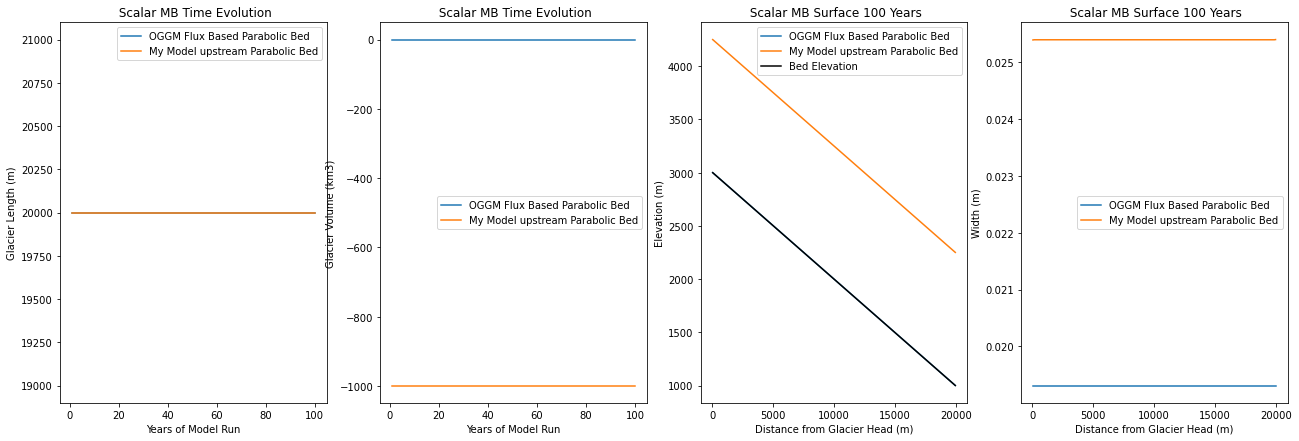

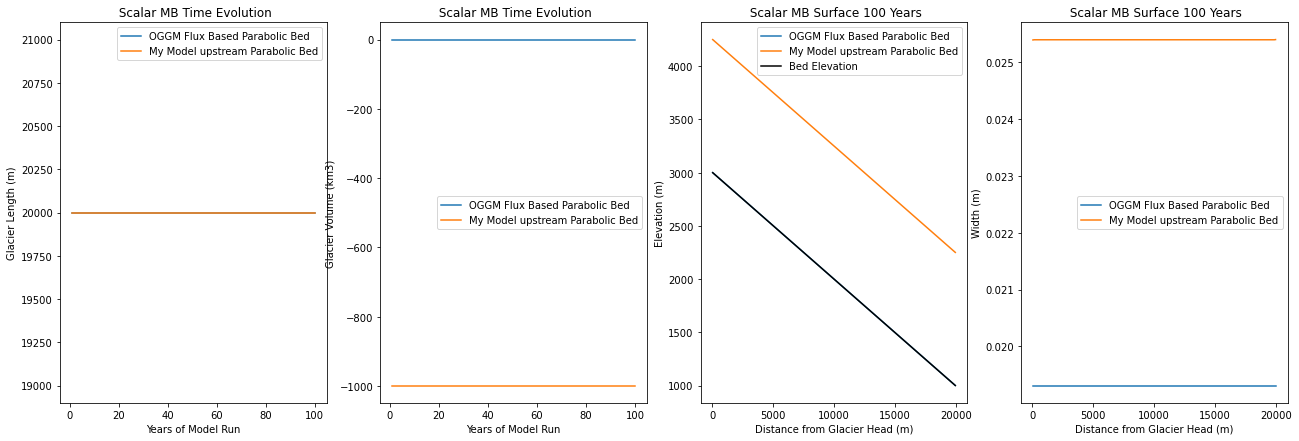

In [25]:
#load and plot models, should fix so doesn't try to plot if didn't run
plot_mymodel = 1 #plot model if 1, can turn off if skewing plots because so off
for j in 2,2:

    if j==1:
        npzfile=np.load("test_bed_linear.npz")
        mm_npzfile=np.load("mymodel_bed_linear.npz")
        mbname = " Linear MB"

    if j==2:
        npzfile=np.load("test_bed_scalar.npz")
        mm_npzfile=np.load("mymodel_bed_scalar.npz")
        mbname = " Scalar MB"
        
    lens, volumes, surface_h, widths, bed_h = npzfile['lens'],npzfile['volume'],npzfile['surface_h'],npzfile['widths'],npzfile['bed_h']
    length, volume, SurfaceElevation, width, bed_hh = mm_npzfile['lens'],mm_npzfile['volume'],mm_npzfile['surface_h'],mm_npzfile['widths'],mm_npzfile['bed_h']
    if j==1: print(mbname,np.mean(m_dot_linear)*SEC_IN_YEAR *20000.* the_wid*1.e-9)
    if j==2: print(mbname,np.mean(m_dot_scalar)*SEC_IN_YEAR *20000.* the_wid*1.e-9)
    print(modelnames)
    print(volumes[:,0],widths[:,0],(surface_h-bed_h)[:,0])#OGGM
    print(methodnames)
    print(volume[:,0],width[:,0],(SurfaceElevation-bed_hh)[:,0]) #my model
    
    fig = plt.figure(figsize=(22,7))
    
    ax1 = fig.add_subplot(1,4,1)
    for i, array in enumerate(lens):
        ax1.plot(yrs, array, label = modelnames[i])
    if plot_mymodel==1: 
        for i, array in enumerate(length):
            ax1.plot(yrs, array, label = methodnames[i])    
    ax1.set_xlabel('Years of Model Run')
    ax1.set_ylabel('Glacier Length (m)')
    ax1.legend()
    ax1.set_title(mbname + " Time Evolution")

    ax2 = fig.add_subplot(1,4,2)
    for i, array in enumerate(volumes):
        ax2.plot(yrs, array, label = modelnames[i])
    if plot_mymodel==1: 
        for i, array in enumerate(volume):
            ax2.plot(yrs, array, label = methodnames[i])
    ax2.set_xlabel('Years of Model Run')
    ax2.set_ylabel('Glacier Volume (km3)')
    ax2.legend()
    ax2.set_title(mbname + " Time Evolution")
    
    ax3 = fig.add_subplot(1,4,3)
    for i, array in enumerate(surface_h):
        ax3.plot(dist, array, label = modelnames[i])
    if plot_mymodel==1: 
        for i, array in enumerate(SurfaceElevation):
            ax3.plot(dist, array, label = methodnames[i])
    ax3.plot(dist,bed_h, 'k',label = "Bed Elevation",)
    ax3.set_xlabel('Distance from Glacier Head (m)')
    ax3.set_ylabel('Elevation (m)')
    ax3.legend()
    #ax3.set_ylim(2500, 3500)
    #ax3.set_xlim(0, 5000)
    ax3.set_title(mbname + " Surface "+str(yrs[-1])+" Years")

    ax4 = fig.add_subplot(1,4,4)
    for i, array in enumerate(widths):
        ax4.plot(dist, array, label = modelnames[i])
    if plot_mymodel==1: 
        for i, array in enumerate(width):
            ax4.plot(dist, array, label = methodnames[i])
    ax4.set_xlabel('Distance from Glacier Head (m)')
    ax4.set_ylabel('Width (m)')
    ax4.legend()
    ax4.set_title(mbname + " Surface "+str(yrs[-1])+" Years")
    
    plt.savefig(mbname[0:7] +str(yrs[-1])+ "_Years.png", bbox_inches='tight')

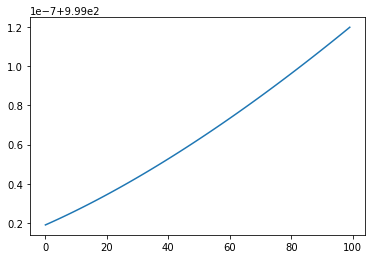

In [26]:
plt.plot((volumes-volume)[0]) #my model has less volume  after 150 years but has more before that, oscillating

In [27]:
print((4.*(surface_h-bed_h)[:,0]/widths[:,0]**2)[0],shape) #should be equal

5000.000000002285 5000.0
